# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of October at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Verbockhaven"
ln1 = "Manon"
fn2 = "Jolivet"
ln2 = "Théo"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_manon_verbockhaven_and_théo_jolivet.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba

0.44.1


In [6]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

1.38 µs ± 31 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

34.5 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [9]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

def l_max_linreg(A, lbda):
    return max([norm(A[i], 2)**2 + lbda for i in range(len(A))])

In [10]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

def l_max_loreg(A, lbda):
    return max([1 / 4 * norm(A[i], 2)**2 + lbda for i in range(len(A))])

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [13]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


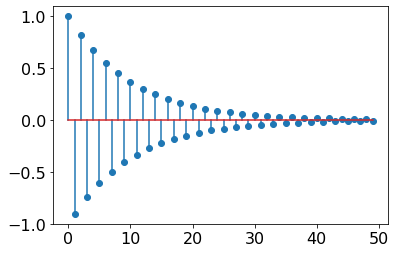

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.298415517739646e-06

In [16]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.018386991840192e-07

### Choice of the model

In [17]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [18]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.5075089944523578


### Get a very precise minimum to compute distances to minimum

In [19]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5379865064617783
1.611704485714224e-09


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [20]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [21]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [22]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x = x - step*grad(x, A, b, lbda)

        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

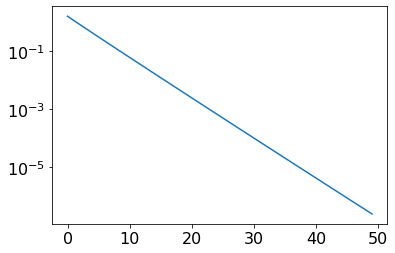

In [23]:
step = 1 / lipschitz_constant(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

plt.plot(monitor_gd.err)
plt.yscale("log")

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [24]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    x_save = x_init.copy()
    y = x_init.copy()
    t = 1.
    t_save = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        x = y.copy() - step*grad(y.copy(), A, b, lbda)
        t = (1 + np.sqrt(1 + 4*t_save**2)) / 2
        y = x.copy() + (t_save - 1) / float(t) * (x.copy() - x_save.copy())
        
        t_save = float(t)
        x_save = x.copy()

    return x, x_list

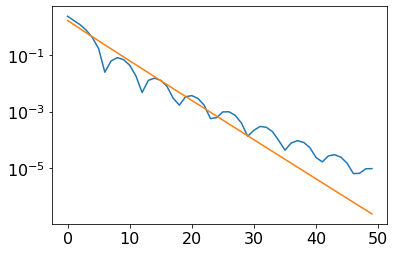

In [25]:
step = 1 / lipschitz_constant(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

plt.plot(monitor_agd.err)
plt.plot(monitor_gd.err)
plt.yscale("log")
plt.show()

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [26]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [27]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [28]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

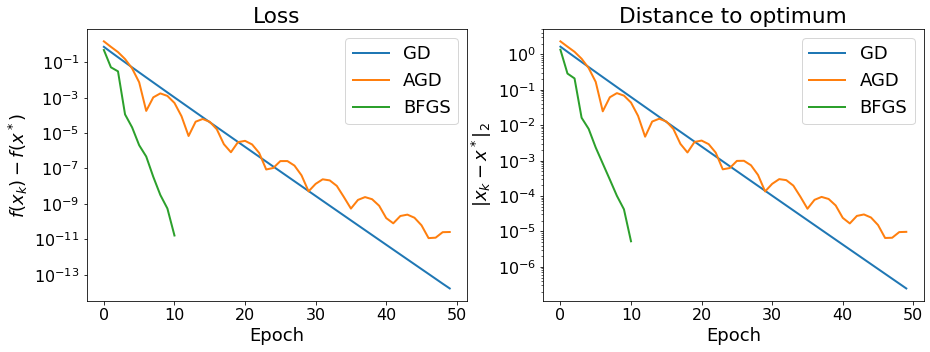

In [29]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

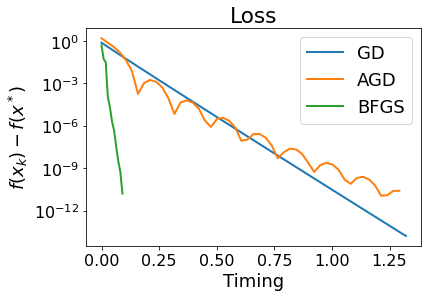

In [30]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3.1) Give some first conclusions about the batch solver studied here
- Q3.2) What do you observe about AGD? is it suprising ?

Q3.1) BFGS performs best in terms of speed and number of iterations at first but doesn't converge to the optimal solution as opposed to AGD and GD.

Q3.2) AGD has a faster convergence speed than GD in terms of iterations because the latter is of the order of O(1/t^2) instead of (1/t). But we observe than it has the same convergence rate as GD, which is surprising.

<a id='stoc'></a> 
## 4. Stochastic methods

*QUESTIONS*:

- Q4) What is the link between ``n_iter`` argument for GD and ``n_iter`` argument for stochastic methods (SGD, SAGA, SVRG)? In other words, why did we introduce ``n_epoch`` for stochastic methods?

We need to plot n_epoch(GD) = n_iter(stoch) * d in order to have a full pass over the data with the stochastic methods.

In [31]:
n_epoch = 50 # number of epochs of deterministic methods

# generate indices of random samples
iis = np.random.randint(0, n, n_epoch*d) # to have the same number of epochs as for GD

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [32]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        x = x - step / np.sqrt(idx + 1) * grad_i(i, x, A, b, lbda)
                
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

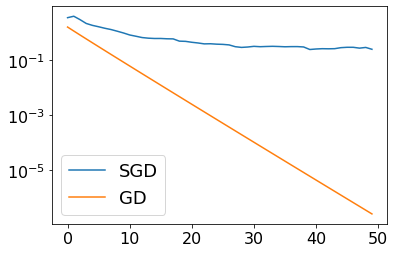

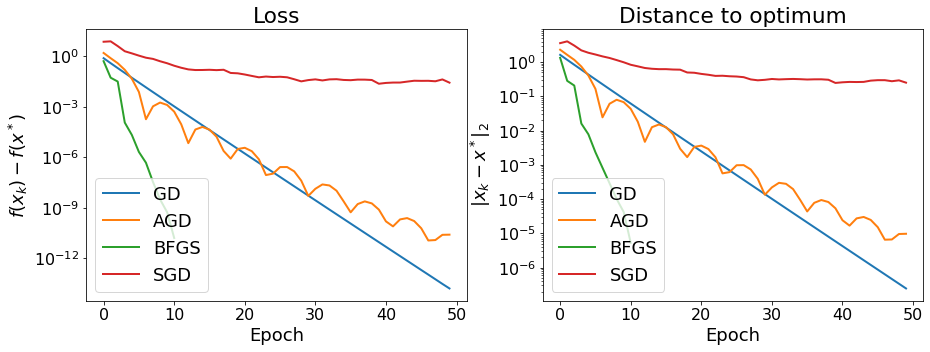

In [33]:
step0 = 1e-1 # 1 / (4 * l_max_linreg(A, lbda)) 
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_epoch*d, step0, store_every=d, args=(A, b, lbda)) # same as in the cell after Q4

plt.plot(monitor_sgd.err, label = "SGD")
plt.plot(monitor_gd.err, label = "GD")
plt.legend()
plt.yscale("log")

monitors = [monitor_gd, monitor_agd, monitor_bfgs, monitor_sgd]

solvers = ["GD", "AGD", "BFGS", "SGD"]

plot_epochs(monitors, solvers)

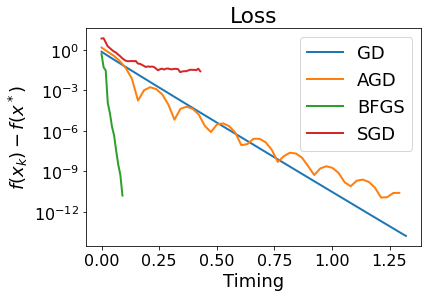

In [34]:
plot_time(monitors, solvers)

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [35]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        averaged_gradient = averaged_gradient - 1/n * gradient_memory[i] + 1/n * grad_i(i, x, A, b, lbda)
        gradient_memory[i] = grad_i(i, x, A, b, lbda)
        x = x - step*averaged_gradient
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [36]:
step = 1 / (16 * l_max_linreg(A, lbda))

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda)) # same as in the cell after Q4

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [37]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        mu = grad(x_old, A, b, lbda)
        
        for t in iis:
            x = x - step*(grad_i(t, x, A, b, lbda) - grad_i(t, x_old, A, b, lbda) + mu)
        x_old = x.copy()
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

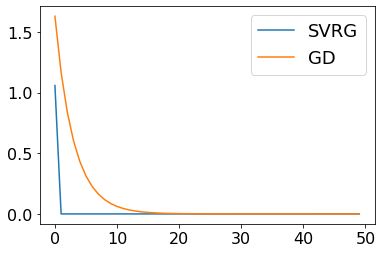

In [38]:
m = d
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda)) # same as in the cell after Q4

plt.plot(monitor_svrg.err, label = "SVRG")
plt.plot(monitor_gd.err, label = "GD")
plt.legend()

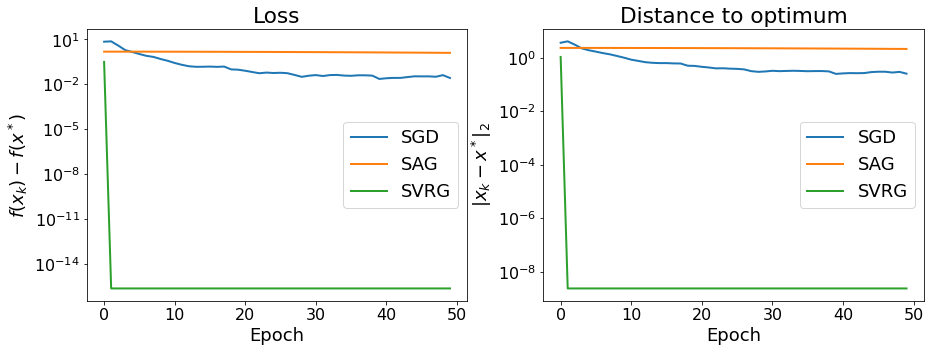

In [39]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

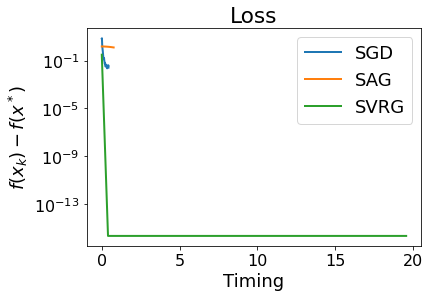

In [40]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

For the stochastic methods, the SGD and SAG algorithms don't converge to the minimum as the SVRG method after the same number of epochs. SVRG also have the fastest convergence rate in time.

<a id='comp'></a> 
## 5. Numerical comparison

<a id='conc'></a>
## 6. Conclusion

__For these questions, only plot relevant examples (do not plot hundreds of figures) and give SHORT answers showing your understanding of the different behaviours.__

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.
- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

For next questions, work **only on logistic regression**
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

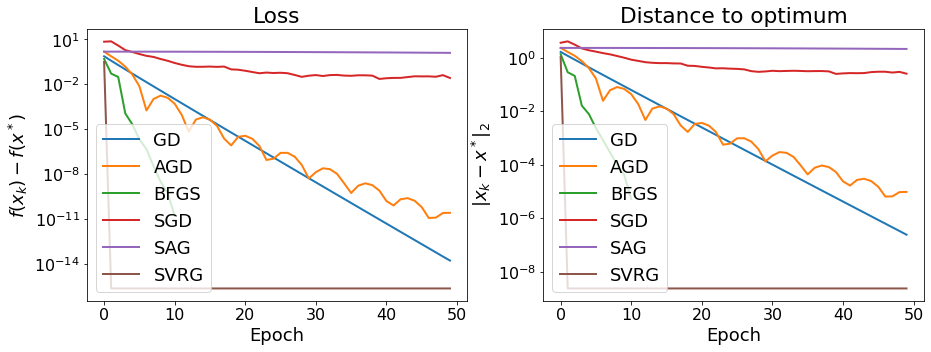

In [41]:
#Plot linear regression for the deterministic and stochastic methods

monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

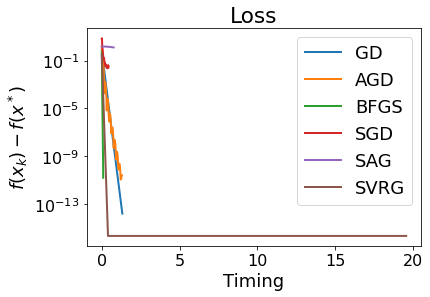

In [42]:
plot_time(monitors, solvers)

In [43]:
#Rewrite parameters for logistic regression
A, b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
lbda = 1. / n ** (0.5)

step = 1 / lipschitz_constant(A, b, lbda)
x_init = np.zeros(d)

#Run deterministic methods
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))


monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

#Run stochastic methods

step0 = 1e-1
monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_epoch*d, step0, store_every=d, args=(A, b, lbda))

step = 1 / (16 * l_max_linreg(A, lbda))
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))

m = d
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))

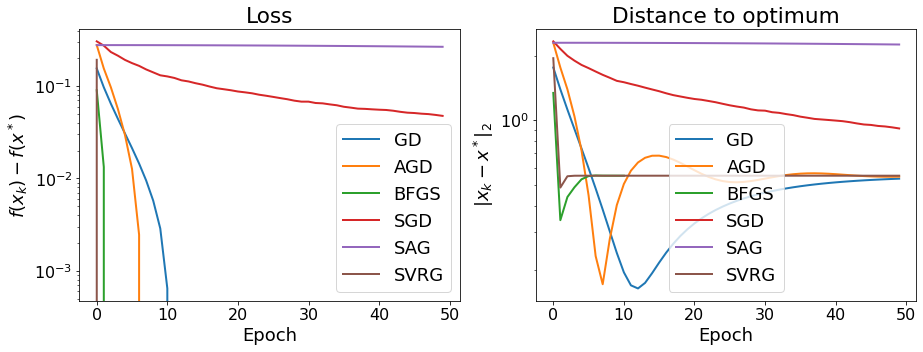

In [44]:
#Plot deterministic and stochastic methods on logistic regression
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)
#plt.xscale("log")

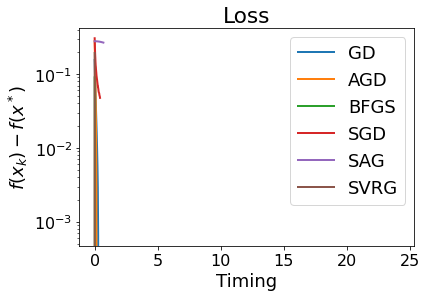

In [45]:
plot_time(monitors, solvers)

Q9) For the linear regression and the log regression, deterministic models perform best in time and epochs compared to the stochastic methods except for SVRG which seems to have the best convergence results.

lambda = 0.0001


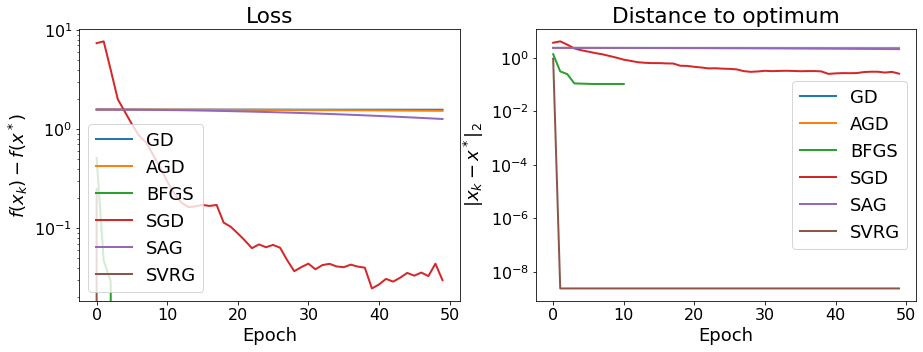

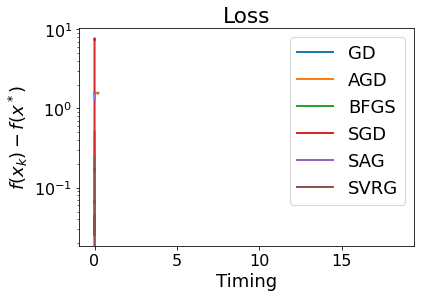

lambda = 0.002575


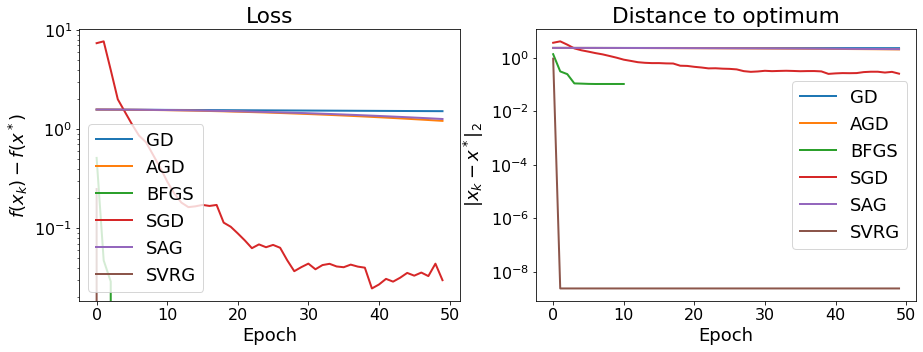

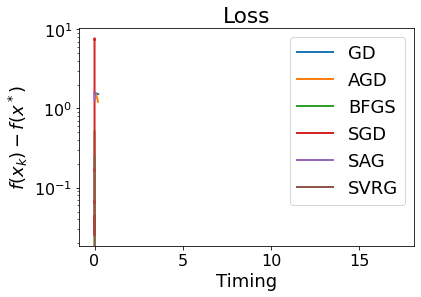

lambda = 0.005050000000000001


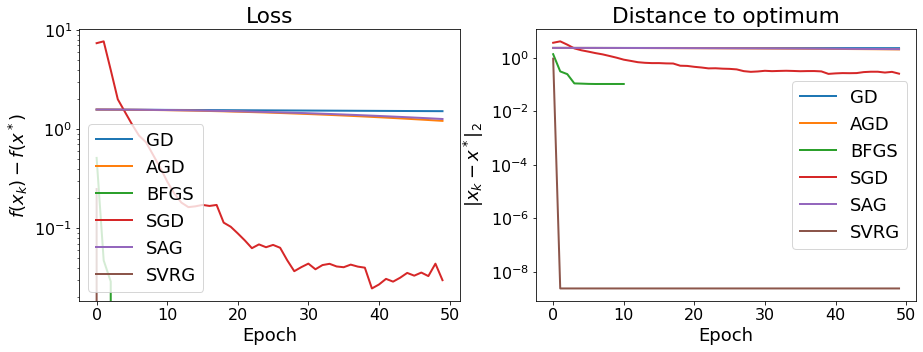

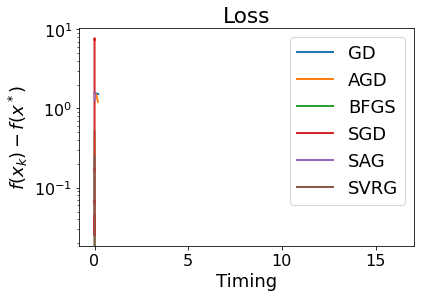

lambda = 0.007525000000000001


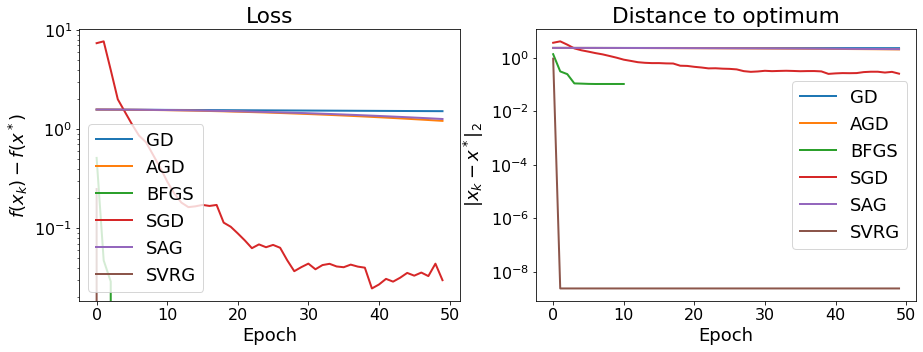

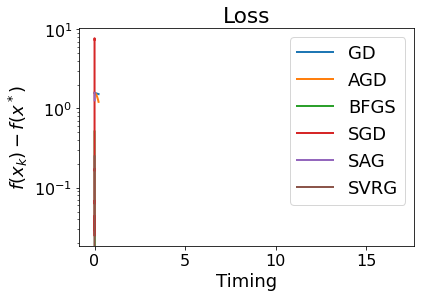

lambda = 0.01


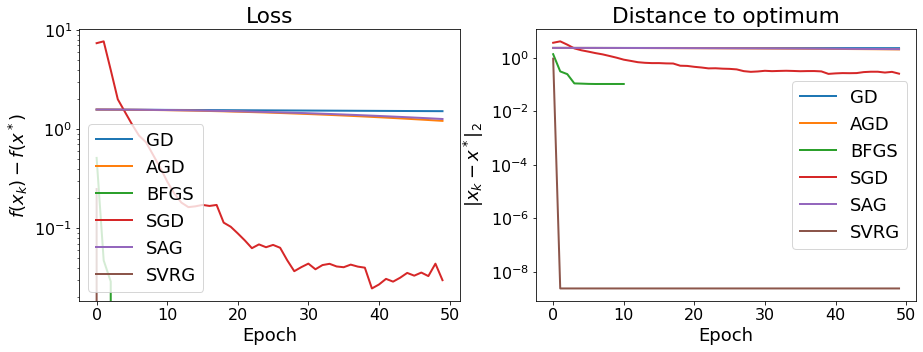

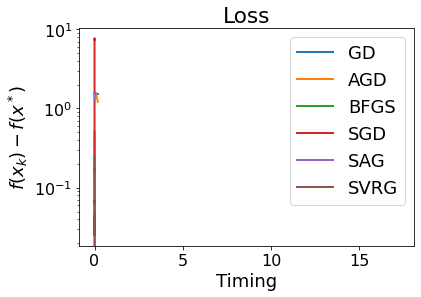

In [55]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)



for lmbd in np.linspace(1/n, 1/np.sqrt(n), 5):
    #Run deterministic methods
    monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
    monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
    monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
    monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

    #Run stochastic methods

    step0 = 1e-1
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis, grad_i, n_epoch*d, step0, store_every=d, args=(A, b, lbda))

    step = 1 / (16 * l_max_linreg(A, lbda))
    monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
    monitor_sag.run(x_init, iis, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))

    m = d
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
    monitor_svrg.run(x_init, iis, grad, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))
    monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

    solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]
    print('lambda =', lmbd)
    plot_epochs(monitors, solvers)
    plt.show()
    plot_time(monitors, solvers)
    plt.show()


CORRELATION = 0.0


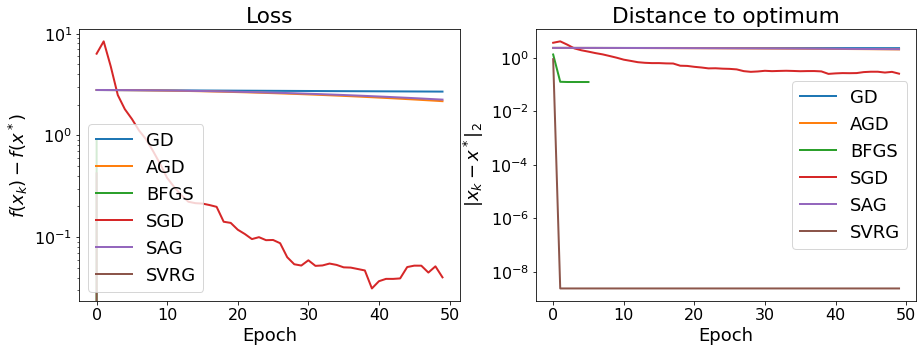

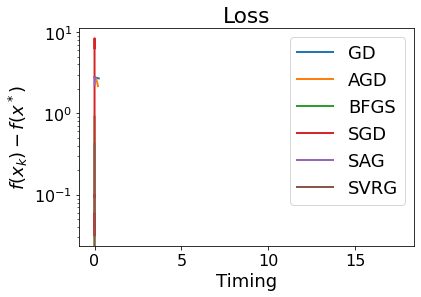

CORRELATION = 0.25


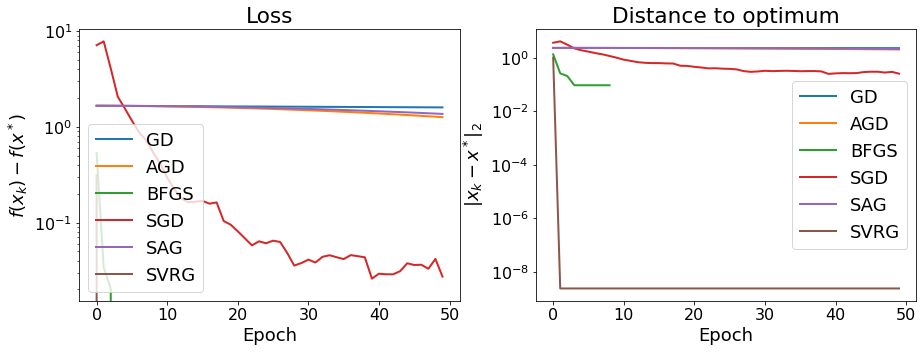

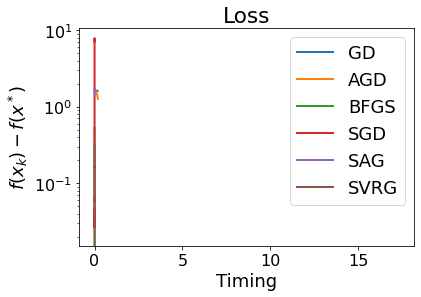

CORRELATION = 0.5


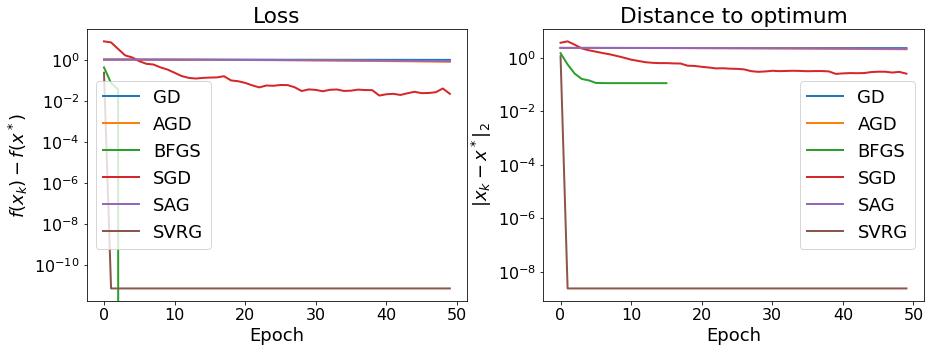

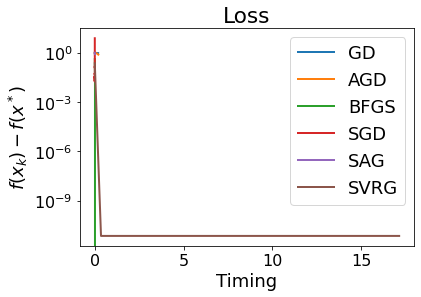

CORRELATION = 0.75


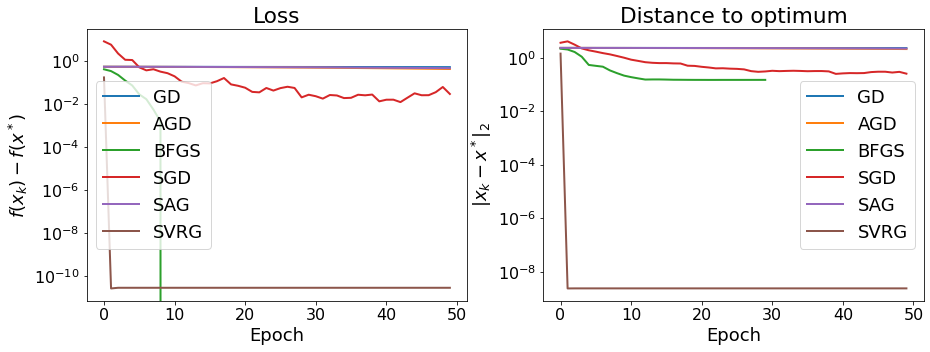

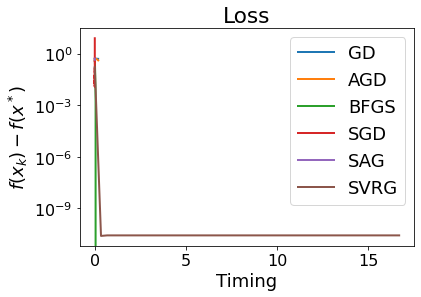

CORRELATION = 1.0


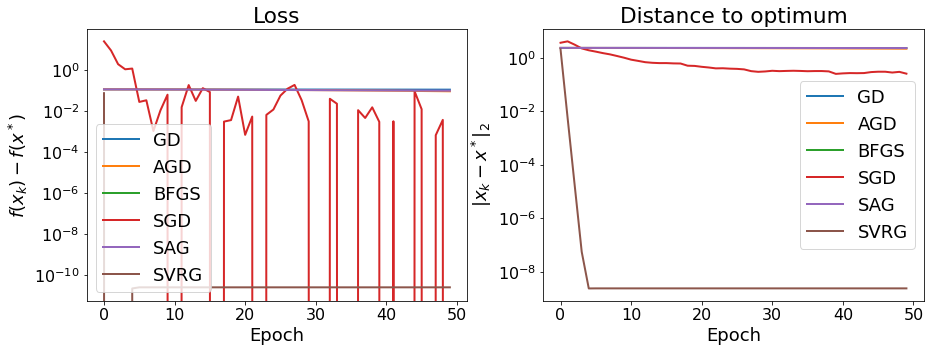

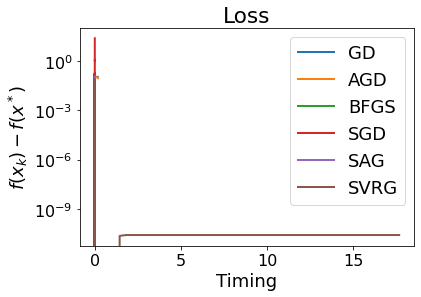

In [56]:
lmbd = 1/n
for corr in np.linspace(0, 1, 5) :
    A, b = simu_linreg(x_model_truth, n, std=1., corr=corr)
    monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
    monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
    monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
    monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

    #Run stochastic methods

    step0 = 1e-1
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis, grad_i, n_epoch*d, step0, store_every=d, args=(A, b, lbda))

    step = 1 / (16 * l_max_linreg(A, lbda))
    monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
    monitor_sag.run(x_init, iis, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))

    m = d
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
    monitor_svrg.run(x_init, iis, grad, grad_i, n_epoch*d, step, store_every=d, args=(A, b, lbda))
    monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

    solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]
    print('CORRELATION =', corr)
    plot_epochs(monitors, solvers)
    plt.show()
    plot_time(monitors, solvers)
    plt.show()